In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df.head()

,FileFolder,FileName,Report_Title,Report_RunDate,Report_AsOfDate,Report_TransactionEffectiveDate,Currency,Institution,Branch,TransactionGroup,TransactionCode,TransactionBackdateFlag,TransactionAmount
0,Generic Random Data,AIBC0101.001,AIBC 0809TTTBB,2014-01-01,2013-12-31,2013-12-30,CAD,1,1,D,CP,Yes,-972.619715
1,Generic Random Data,AIBC0101.001,AIBC 0809TTTBB,2014-01-01,2013-12-31,2013-12-30,CAD,1,1,D,UR,Yes,-75.956876
2,Generic Random Data,AIBC0101.001,AIBC 0809TTTBB,2014-01-01,2013-12-31,2013-12-30,CAD,1,1,C,CP,Yes,127.430470
3,Generic Random Data,AIBC0101.001,AIBC 0809TTTBB,2014-01-01,2013-12-31,2013-12-30,CAD,1,1,D,UR,Yes,-38.300469
4,Generic Random Data,AIBC0101.001,AIBC 0809TTTBB,2014-01-01,2013-12-31,2013-12-30,CAD,1,1,D,UR,Yes,-117.467137


In [16]:
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode"])
df.shape

(67731, 3)

In [17]:
## Split data into Debit and Credit
credit_df = df[df["TransactionGroup"] == "C"].copy()
debit_df = df[df["TransactionGroup"] == "D"].copy()
print("Credit Shape: ", credit_df.shape)
print("Debit Shape: ", debit_df.shape)

Credit Shape:  (43402, 3)
Debit Shape:  (24329, 3)


In [18]:
## Group by date
daily_credit = credit_df.groupby("Report_TransactionEffectiveDate")["TransactionAmount"].sum().asfreq("D")
daily_debit = debit_df.groupby("Report_TransactionEffectiveDate")["TransactionAmount"].sum().asfreq("D")

print("Daily Credit Missing Values: ", daily_credit.isnull().sum())
print("Daily Debit Missing Values: ", daily_debit.isnull().sum())

Daily Credit Missing Values:  809
Daily Debit Missing Values:  787


In [19]:
## Fill n/a with 0
daily_credit = daily_credit.fillna(method="ffill").fillna(method="bfill")
daily_debit = daily_debit.fillna(method="ffill").fillna(method="bfill")

print("Daily Credit Missing Values: ", daily_credit.isnull().sum())
print("Daily Debit Missing Values: ", daily_debit.isnull().sum())

Daily Credit Missing Values:  0
Daily Debit Missing Values:  0


In [20]:
## Rows of daily credit and debit transactions
print("Daily Credit Rows: ", daily_credit.shape[0])
print("Daily Debit Rows: ", daily_debit.shape[0])

Daily Credit Rows:  2559
Daily Debit Rows:  2559


In [21]:
## Function to split train and test sets
def split_train_test_time_series(data, n_splits=5, test_size=None):
    X = data.values.reshape(-1, 1)
    
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=None, test_size=test_size)
    
    train_indices = []
    test_indices = []
    
    for train_index, test_index in tscv.split(X):
        train_indices.append(train_index)
        test_indices.append(test_index)
    
    return data.iloc[train_indices[-1]], data.iloc[test_indices[-1]]

## Split train and test sets
credit_train, credit_test = split_train_test_time_series(daily_credit, test_size=int(len(daily_credit) * 0.2))
debit_train, debit_test = split_train_test_time_series(daily_debit, test_size=int(len(daily_debit) * 0.2))


In [22]:
## Pick p,d,m for arima model using auto-arima for the most optimal parameters (Non-seasonal)
def create_arima_model(train, test):
    ## Find Best parameters 
    auto_model = auto_arima(train, start_p= 0, start_p0=0, max_p=5, max_q=5,m=1, d=None, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True)
    ## Fit model
    model = ARIMA(train, order=auto_model.order)
    model_results = model.fit()
    
    ## Forecast on test set
    forecast = model_results.forecast(steps=len(test))
    
    ## Error metrics
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    
    return {
        'model': model_results,
        'forecast': forecast,
        'order': auto_model.order,
        'mae': mae,
        'mse': mse,
        'rmse': rmse
    }

forecast_credit_results = create_arima_model(credit_train, credit_test)
forecast_debit_results = create_arima_model(debit_train, debit_test)

In [23]:
## Print Performance
print("Credit Transaction Model:")
print(f"ARIMA Order: {forecast_credit_results['order']}")
print(f"Mean Absolute Error: {forecast_credit_results['mae']}")
print(f"Root Mean Squared Error: {forecast_credit_results['rmse']}")

print("\nDebit Transaction Model:")
print(f"ARIMA Order: {forecast_debit_results['order']}")
print(f"Mean Absolute Error: {forecast_debit_results['mae']}")
print(f"Root Mean Squared Error: {forecast_debit_results['rmse']}")


Credit Transaction Model:
ARIMA Order: (3, 1, 5)
Mean Absolute Error: 18189.012665446695
Root Mean Squared Error: 23833.80391066019

Debit Transaction Model:
ARIMA Order: (5, 1, 0)
Mean Absolute Error: 11667.265263745578
Root Mean Squared Error: 13936.23027370524


In [24]:
## Perform full forecast for 90 days
def create_full_forecast_model(data, order):
    model = ARIMA(data, order=order)
    model_results = model.fit()
    
    forecast_steps = 90
    forecast = model_results.forecast(steps=forecast_steps)
    return forecast

full_forecast_credit_results = create_full_forecast_model(daily_credit, forecast_credit_results['order'])
full_forecast_debit_results = create_full_forecast_model(daily_debit, forecast_debit_results['order'])

In [25]:
## Create full forecaste DataFrame
full_forecast_df = pd.DataFrame({
    "PredictedCreditAmount": full_forecast_credit_results,
    "PredictedDebitAmount": full_forecast_debit_results
})

full_forecast_df["AveragePredictedAmount"] = (full_forecast_df["PredictedCreditAmount"] + full_forecast_df["PredictedDebitAmount"])
full_forecast_df

,PredictedCreditAmount,PredictedDebitAmount,AveragePredictedAmount
2021-01-01,92601.793121,-31836.464532,60765.328590
2021-01-02,60797.101213,-30434.167365,30362.933848
2021-01-03,51926.860986,-30063.880571,21862.980415
2021-01-04,64007.031702,-32138.432632,31868.599071
2021-01-05,50733.587146,-32756.903500,17976.683646
...,...,...,...
2021-03-27,58898.790155,-32308.735269,26590.054886
2021-03-28,50416.233716,-32308.735269,18107.498447
2021-03-29,61893.706556,-32308.735269,29584.971286
2021-03-30,49699.648231,-32308.735269,17390.912961


<Figure size 1500x1000 with 0 Axes>

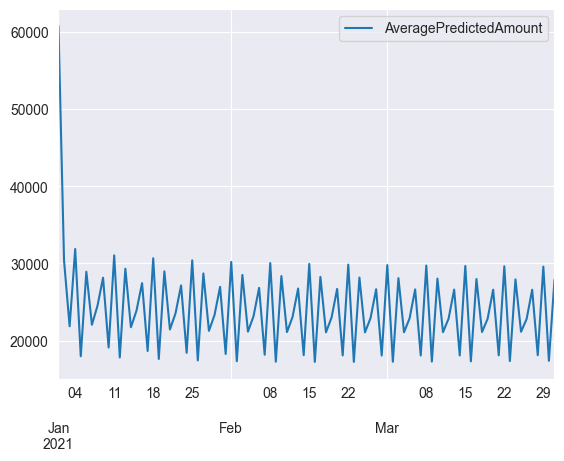

In [26]:
plt.figure(figsize=(15, 10))
full_forecast_df.plot(y='AveragePredictedAmount', kind='line')
plt.show()